#Library imports

In [ ]:
!pip install torch torchdata transformers datasets

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
import csv
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import random
import numpy as np
import spacy
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


#Load Dataset from HugginFace and split

In [ ]:
# Load the SQuAD dataset
huggingface_dataset_name = "squad"
dataset = load_dataset(huggingface_dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
#The first 95% of `train` split.
train_dataset = load_dataset('squad', split='train[:95%]')
#The last 5% of `train` split.
val_dataset = load_dataset('squad', split='train[95%:]')
#validation set will be used as test set
test_dataset = load_dataset('squad', split='validation')


In [ ]:
example_indices = [40, 200]
dash_line = '-'.join('' for x in range(100))
for i, index in enumerate(example_indices):
  print(dash_line)
  print("Ex", i+1)
  print(dash_line)
  print('Context')
  print(train_dataset[index]['context'])
  print('Question')
  print(train_dataset[index]['question'])
  print('Answer')
  print(train_dataset[index]['answers'])

for i, index in enumerate(example_indices):
  print(dash_line)
  print("Ex", i+1)
  print(dash_line)
  print('Context')
  print(test_dataset[index]['context'])
  print('Question')
  print(test_dataset[index]['question'])
  print('Answer')
  print(test_dataset[index]['answers'])

---------------------------------------------------------------------------------------------------
Ex 1
---------------------------------------------------------------------------------------------------
Context
Notre Dame is known for its competitive admissions, with the incoming class enrolling in fall 2015 admitting 3,577 from a pool of 18,156 (19.7%). The academic profile of the enrolled class continues to rate among the top 10 to 15 in the nation for national research universities. The university practices a non-restrictive early action policy that allows admitted students to consider admission to Notre Dame as well as any other colleges to which they were accepted. 1,400 of the 3,577 (39.1%) were admitted under the early action plan. Admitted students came from 1,311 high schools and the average student traveled more than 750 miles to Notre Dame, making it arguably the most representative university in the United States. While all entering students begin in the College of the Fi

#Load Model & Tokenizer

In [ ]:
model_name = 'google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# How to use tokenizer?
sentence = "What time is it?"
sentence_encoded = tokenizer(sentence, return_tensors='pt')
sentence_encoded

{'input_ids': tensor([[363,  97,  19,  34,  58,   1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [ ]:
sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0], skip_special_tokens=True)
sentence_decoded

'What time is it?'

#Zero-Shot/One-shot/Few-shot Learning demontrations and model predictions on specific indices


**max_new_tokens**: the maximum number of tokens to generate. In other words, the size of the output sequence, not including the tokens in the prompt.

In [ ]:
# select an example
example_index = [200]
# get the passage
context = train_dataset[example_index]['context']
# get the human question
question = train_dataset[example_index]['question']
# Configurations
generation_config = GenerationConfig(max_new_tokens=25)
# Encode input:
inputs_encoded = tokenizer(context,question,return_tensors='pt')
# Model Output:
model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]
# Decode the output
zero_output = tokenizer.decode(model_output, skip_special_tokens=True)
print("Input: ", context)
print(dash_line)
print( "Human question: ", question)
print(dash_line)
print("Model Output: ", zero_output)

Input:  ["In 1842, the Bishop of Vincennes, Célestine Guynemer de la Hailandière, offered land to Father Edward Sorin of the Congregation of the Holy Cross, on the condition that he build a college in two years. Fr. Sorin arrived on the site with eight Holy Cross brothers from France and Ireland on November 26, 1842, and began the school using Father Stephen Badin's old log chapel. He soon erected additional buildings, including Old College, the first church, and the first main building. They immediately acquired two students and set about building additions to the campus."]
---------------------------------------------------------------------------------------------------
Human question:  ['In what year was Father Edward Sorin given two years to create a college?']
---------------------------------------------------------------------------------------------------
Model Output:  1842


In [ ]:
def make_example_prompt(example_indices, example_index_to_answer):
  prompt = ""

  for index in example_indices:

    context = train_dataset[index]['context']
    question = train_dataset[index]['question']
    answer= train_dataset[index]['answers']
    # prompt includes the passage, the question and the answer
    prompt += f"""
    Passage:
    {context}

    Read the passage above and answer the following question:
    {question}

    The answer is:
    {answer}
    """

  # get the example passage
  context = train_dataset[example_index_to_answer]['context']
  question = train_dataset[example_index_to_answer]['question']
  prompt += f"""
    Passage:
    {context}

    Read the passage above and answer the following question:
    {question}

    The answer is:
    """

  return prompt

In [ ]:
example_indices = [40]
example_index_to_answer = 200
one_shot_prompt = make_example_prompt(example_indices, example_index_to_answer)

print(one_shot_prompt)


    Passage:
    Notre Dame is known for its competitive admissions, with the incoming class enrolling in fall 2015 admitting 3,577 from a pool of 18,156 (19.7%). The academic profile of the enrolled class continues to rate among the top 10 to 15 in the nation for national research universities. The university practices a non-restrictive early action policy that allows admitted students to consider admission to Notre Dame as well as any other colleges to which they were accepted. 1,400 of the 3,577 (39.1%) were admitted under the early action plan. Admitted students came from 1,311 high schools and the average student traveled more than 750 miles to Notre Dame, making it arguably the most representative university in the United States. While all entering students begin in the College of the First Year of Studies, 25% have indicated they plan to study in the liberal arts or social sciences, 24% in engineering, 24% in business, 24% in science, and 3% in architecture.

    Read the passa

In [ ]:
# Encode input THE ONLY DIFFERENCE IS HERE
inputs_encoded = tokenizer(one_shot_prompt, return_tensors='pt')

# Model Output
model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

# Decode the output
one_output = tokenizer.decode(model_output, skip_special_tokens=True)


print(dash_line)
print("Ex: ", i+1)
print(dash_line)
print("Input: ", context)
print(dash_line)
print( "Human question: ", question)
print(dash_line)
print(" ONE SHOT Output: ", one_output)

---------------------------------------------------------------------------------------------------
Ex:  2
---------------------------------------------------------------------------------------------------
Input:  ["In 1842, the Bishop of Vincennes, Célestine Guynemer de la Hailandière, offered land to Father Edward Sorin of the Congregation of the Holy Cross, on the condition that he build a college in two years. Fr. Sorin arrived on the site with eight Holy Cross brothers from France and Ireland on November 26, 1842, and began the school using Father Stephen Badin's old log chapel. He soon erected additional buildings, including Old College, the first church, and the first main building. They immediately acquired two students and set about building additions to the campus."]
---------------------------------------------------------------------------------------------------
Human question:  ['In what year was Father Edward Sorin given two years to create a college?']
----------------

Few_shot (K=3)

In [ ]:
example_indices = [40, 80, 120]
example_index_to_answer = 200
few_shot_prompt = make_example_prompt(example_indices, example_index_to_answer)

# Encode input THE ONLY DIFFERENCE IS HERE
inputs_encoded = tokenizer(few_shot_prompt, return_tensors='pt')

# Model Output
model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

# Decode the output
few3_output = tokenizer.decode(model_output, skip_special_tokens=True)

Few_shot (K=6)

In [ ]:
example_indices = [40, 80, 120, 130, 140, 150]
example_index_to_answer = 200
few_shot_prompt = make_example_prompt(example_indices, example_index_to_answer)

# Encode input THE ONLY DIFFERENCE IS HERE
inputs_encoded = tokenizer(few_shot_prompt, return_tensors='pt')

# Model Output
model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

# Decode the output
few6_output = tokenizer.decode(model_output, skip_special_tokens=True)

Few_shot (K=9)

In [ ]:
example_indices = [40, 80, 120, 130, 140, 150, 160,170,180]
example_index_to_answer = 200
few_shot_prompt = make_example_prompt(example_indices, example_index_to_answer)

# Encode input THE ONLY DIFFERENCE IS HERE
inputs_encoded = tokenizer(few_shot_prompt,return_tensors='pt')

# Model Output
model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

# Decode the output
few9_output = tokenizer.decode(model_output, skip_special_tokens=True)


In [ ]:
print("Input: ", context)
print(dash_line)
print( "Human question: ", question)
print(dash_line)
print("Zero-Shot Output: ", zero_output)
print(dash_line)
print("One-Shot Output: ", one_output)
print(dash_line)
print("Few-Shot Output: ", few3_output)
print(dash_line)
print("Few-Shot Output: ", few6_output)
print(dash_line)
print("Few-Shot Output: ", few9_output)

Input:  ["In 1842, the Bishop of Vincennes, Célestine Guynemer de la Hailandière, offered land to Father Edward Sorin of the Congregation of the Holy Cross, on the condition that he build a college in two years. Fr. Sorin arrived on the site with eight Holy Cross brothers from France and Ireland on November 26, 1842, and began the school using Father Stephen Badin's old log chapel. He soon erected additional buildings, including Old College, the first church, and the first main building. They immediately acquired two students and set about building additions to the campus."]
---------------------------------------------------------------------------------------------------
Human question:  ['In what year was Father Edward Sorin given two years to create a college?']
---------------------------------------------------------------------------------------------------
Zero-Shot Output:  1842
---------------------------------------------------------------------------------------------------

#Funcs for evaluation

In [ ]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def evaluate(gold_answers, predictions):
    f1 = exact_match = total = 0

    for ground_truths, prediction in zip(gold_answers, predictions):
      total += 1
      exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
      f1 += metric_max_over_ground_truths(
          f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

  # Zero-shot : Generate answers for the whole test set

In [ ]:
results = []

for example in test_dataset:
    context = example['context']
    question = example['question']
    true_answer = example['answers']['text']
    # Encode input
    inputs_encoded = tokenizer(context, question, return_tensors='pt').to(device)

    # Generate model output on GPU
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    model_output_decoded = tokenizer.decode(model_output, skip_special_tokens=True)


    evaluation_results = evaluate([true_answer], [model_output_decoded])
    results.append({
        'context': context,
        'question': question,
        'true_answer': true_answer,
        'zero_output': model_output_decoded,
        'evaluation_results': evaluation_results
    })

results_df = pd.DataFrame(results)
results_df.to_csv('zeroshot_results_with_answers_exact_match_and_f1.csv', index=False)



In [ ]:
zero_shot_results_df = pd.read_csv('zeroshot_results_with_answers_exact_match_and_f1.csv')
zero_shot_results_df

,context,question,true_answer,zero_output,evaluation_results
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"['Carolina Panthers', 'Carolina Panthers', 'Ca...",Carolina Panthers,"{'exact_match': 100.0, 'f1': 100.0}"
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"['Santa Clara, California', ""Levi's Stadium"", ...",Levi's Stadium in the San Francisco Bay Area a...,"{'exact_match': 100.0, 'f1': 100.0}"
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"['gold', 'gold', 'gold']",gold,"{'exact_match': 100.0, 'f1': 100.0}"
...,...,...,...,...,...
10565,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"['kilogram-force', 'pound-force', 'kilogram-fo...",kilogram-force,"{'exact_match': 100.0, 'f1': 100.0}"
10566,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"['kilopond', 'kilopond', 'kilopond', 'kilopond...",kilopond,"{'exact_match': 100.0, 'f1': 100.0}"
10567,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"['slug', 'metric slug', 'metric slug', 'metric...",slug,"{'exact_match': 100.0, 'f1': 100.0}"
10568,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"['kip', 'kip', 'kip', 'kip', 'kip']",sthène,"{'exact_match': 0.0, 'f1': 0.0}"


In [ ]:
# Compute the average exact match and F1 scores
average_exact_match_0_shot = zero_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_0_shot = zero_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_0_shot)
print("Average F1 Score:", average_f1_0_shot)


Average Exact Match: 73.03689687795648
Average F1 Score: 81.87277917077199


#One-shot: Generate answers for the whole test set

In [ ]:
def make_prompt(example_indices, dataset):
    prompt = ""
    for index in example_indices:
        context = train_dataset[index]['context']
        question = train_dataset[index]['question']
        answer = train_dataset[index]['answers']

        prompt += f"""
        Passage:
        {context}

        Read the passage above and answer the following question:
        {question}

        The answer is:
        {answer}
        """

    context_to_answer = dataset['context']
    question_to_answer = dataset['question']
    prompt += f"""
        Passage:
        {context_to_answer}

        Read the passage above and answer the following question:
        {question_to_answer}

        The answer is:
        """

    return prompt

In [ ]:
one_shot_results = []

for index, example in enumerate(test_dataset):
    example_index_to_answer = index
    true_answer = example['answers']['text']
    # Generate one-shot learning prompt
    one_shot_prompt = make_prompt([40], example)  # Example_index is the same for each example

    # Encode input for one-shot learning
    inputs_encoded = tokenizer(one_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    one_output = tokenizer.decode(model_output, skip_special_tokens=True)

    evaluation_results = evaluate([true_answer], [one_output])

    one_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'one_output': one_output,
        'evaluation_results': evaluation_results
    })

one_shot_results_df = pd.DataFrame(one_shot_results)
one_shot_results_df.to_csv('oneshot_results_with_answers_exact_match_and_f1.csv', index=False)


In [ ]:
one_shot_results_df = pd.read_csv('oneshot_results_with_answers_exact_match_and_f1.csv')
one_shot_results_df

,context,question,true_answer,one_output,evaluation_results
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"['Carolina Panthers', 'Carolina Panthers', 'Ca...",Carolina Panthers,"{'exact_match': 100.0, 'f1': 100.0}"
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"['Santa Clara, California', ""Levi's Stadium"", ...",Levi's Stadium,"{'exact_match': 100.0, 'f1': 100.0}"
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"['gold', 'gold', 'gold']",gold,"{'exact_match': 100.0, 'f1': 100.0}"
...,...,...,...,...,...
10565,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"['kilogram-force', 'pound-force', 'kilogram-fo...",kilogram-force,"{'exact_match': 100.0, 'f1': 100.0}"
10566,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"['kilopond', 'kilopond', 'kilopond', 'kilopond...",kilopond,"{'exact_match': 100.0, 'f1': 100.0}"
10567,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"['slug', 'metric slug', 'metric slug', 'metric...",slug,"{'exact_match': 100.0, 'f1': 100.0}"
10568,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"['kip', 'kip', 'kip', 'kip', 'kip']",kip,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
average_exact_match_1_shot = one_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_1_shot = one_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_1_shot)
print("Average F1 Score:", average_f1_1_shot)

Average Exact Match: 82.7057710501419
Average F1 Score: 89.66670046788138


#Few-shot: Selecting number of demonstrations on the validation set

k=3

In [ ]:
few3_shot_results = []

for index, example in enumerate(val_dataset):
    # Example index to answer is the current index in the validation dataset
    example_index_to_answer = index

    # Generate few-shot learning prompt
    few3_shot_prompt = make_prompt([40, 80, 120], example)  # Example_indices are the same for each example in the validation set

    # Encode input for few-shot learning
    inputs_encoded = tokenizer(few3_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    few3_output = tokenizer.decode(model_output, skip_special_tokens=True)

    true_answer = example['answers']['text']
    evaluation_results = evaluate([true_answer], [few3_output])  # Wrap true_answer in a list

    few3_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'few3_output': few3_output,
        'evaluation_results': evaluation_results
    })

few3_shot_results_df = pd.DataFrame(few3_shot_results)
few3_shot_results_df.to_csv('3shot_results_with_answers_exact_match_and_f1.csv', index=False)

In [ ]:
few3_shot_results_df = pd.read_csv('3shot_results_with_answers_exact_match_and_f1.csv')
few3_shot_results_df

,context,question,true_answer,few3_output,evaluation_results
0,Although one of the main obstacles still facin...,Where did Egyptian plan to get funds to use fo...,['newly acquired third mobile license ($3 bill...,third mobile license,"{'exact_match': 0.0, 'f1': 50.0}"
1,Although one of the main obstacles still facin...,Where did Egypt rank in Corruption perceptions...,['114 out of 177'],114,"{'exact_match': 0.0, 'f1': 40.0}"
2,Egypt's most prominent multinational companies...,What are Egypt's 2 most prominent multinationa...,['Orascom Group and Raya Contact Center'],Orascom Group and Raya Contact Center,"{'exact_match': 100.0, 'f1': 100.0}"
3,Egypt's most prominent multinational companies...,What sector has expanded radiply by selling ou...,['information technology (IT)'],information technology (IT),"{'exact_match': 100.0, 'f1': 100.0}"
4,Egypt's most prominent multinational companies...,What has stimulated IT sector?,['new Egyptian entrepreneurs with government e...,new Egyptian entrepreneurs,"{'exact_match': 0.0, 'f1': 66.66666666666666}"
...,...,...,...,...,...
4375,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,['Oregon'],Oregon,"{'exact_match': 100.0, 'f1': 100.0}"
4376,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,['Rangoon'],Rangoon,"{'exact_match': 100.0, 'f1': 100.0}"
4377,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,['Minsk'],Minsk,"{'exact_match': 100.0, 'f1': 100.0}"
4378,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,['1975'],1975,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
average_exact_match_3_shot = few3_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_3_shot = few3_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_3_shot)
print("Average F1 Score:", average_f1_3_shot)

Average Exact Match: 72.99086757990868
Average F1 Score: 85.85226446639383


k=6

In [ ]:
few6_shot_results = []

# Loop through the test dataset
for index, example in enumerate(val_dataset):
    # Example index to answer is the current index in the validation dataset
    example_index_to_answer = index

    # Generate few-shot learning prompt
    few6_shot_prompt = make_prompt([40, 80, 120, 130, 140, 150], example)

    # Encode input for one-shot learning
    inputs_encoded = tokenizer(few6_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    few6_output = tokenizer.decode(model_output, skip_special_tokens=True)


    true_answer = example['answers']['text']
    evaluation_results = evaluate([true_answer], [few6_output])


    few6_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'few6_output': few6_output,
        'evaluation_results': evaluation_results
    })

few6_shot_results_df = pd.DataFrame(few6_shot_results)
few6_shot_results_df.to_csv('6shot_results_with_answers_exact_match_and_f1.csv', index=False)

In [ ]:
few6_shot_results_df = pd.read_csv('6shot_results_with_answers_exact_match_and_f1.csv')
few6_shot_results_df

,context,question,true_answer,few6_output,evaluation_results
0,Although one of the main obstacles still facin...,Where did Egyptian plan to get funds to use fo...,['newly acquired third mobile license ($3 bill...,third mobile license,"{'exact_match': 0.0, 'f1': 50.0}"
1,Although one of the main obstacles still facin...,Where did Egypt rank in Corruption perceptions...,['114 out of 177'],114,"{'exact_match': 0.0, 'f1': 40.0}"
2,Egypt's most prominent multinational companies...,What are Egypt's 2 most prominent multinationa...,['Orascom Group and Raya Contact Center'],Orascom Group and Raya Contact Center,"{'exact_match': 100.0, 'f1': 100.0}"
3,Egypt's most prominent multinational companies...,What sector has expanded radiply by selling ou...,['information technology (IT)'],information technology (IT),"{'exact_match': 100.0, 'f1': 100.0}"
4,Egypt's most prominent multinational companies...,What has stimulated IT sector?,['new Egyptian entrepreneurs with government e...,new Egyptian entrepreneurs,"{'exact_match': 0.0, 'f1': 66.66666666666666}"
...,...,...,...,...,...
4375,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,['Oregon'],Oregon,"{'exact_match': 100.0, 'f1': 100.0}"
4376,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,['Rangoon'],Rangoon,"{'exact_match': 100.0, 'f1': 100.0}"
4377,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,['Minsk'],Minsk,"{'exact_match': 100.0, 'f1': 100.0}"
4378,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,['1975'],1975,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
# Compute the average exact match and F1 scores
average_exact_match_6_shot = few6_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_6_shot = few6_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_6_shot)
print("Average F1 Score:", average_f1_6_shot)

Average Exact Match: 72.37442922374429
Average F1 Score: 85.36416704420726


k=9

In [ ]:
few9_shot_results = []

for index, example in enumerate(val_dataset):
    # Example index to answer is the current index in the validation dataset
    example_index_to_answer = index

    # Generate one-shot learning prompt
    few9_shot_prompt = make_prompt([40, 80, 120, 130, 140, 150,160,170,180], example)

    # Encode input for one-shot learning
    inputs_encoded = tokenizer(few9_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    few9_output = tokenizer.decode(model_output, skip_special_tokens=True)

    true_answer = example['answers']['text']
    evaluation_results = evaluate([true_answer], [few9_output])


    few9_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'few9_output': few9_output,
        'evaluation_results': evaluation_results
    })

few9_shot_results_df = pd.DataFrame(few9_shot_results)
few9_shot_results_df.to_csv('9shot_results_with_answers_exact_match_and_f1.csv', index=False)

In [ ]:
few9_shot_results_df = pd.read_csv('9shot_results_with_answers_exact_match_and_f1.csv')
few9_shot_results_df

,context,question,true_answer,few9_output,evaluation_results
0,Although one of the main obstacles still facin...,Where did Egyptian plan to get funds to use fo...,['newly acquired third mobile license ($3 bill...,third mobile license,"{'exact_match': 0.0, 'f1': 50.0}"
1,Although one of the main obstacles still facin...,Where did Egypt rank in Corruption perceptions...,['114 out of 177'],114,"{'exact_match': 0.0, 'f1': 40.0}"
2,Egypt's most prominent multinational companies...,What are Egypt's 2 most prominent multinationa...,['Orascom Group and Raya Contact Center'],Orascom Group and Raya Contact Center,"{'exact_match': 100.0, 'f1': 100.0}"
3,Egypt's most prominent multinational companies...,What sector has expanded radiply by selling ou...,['information technology (IT)'],information technology (IT),"{'exact_match': 100.0, 'f1': 100.0}"
4,Egypt's most prominent multinational companies...,What has stimulated IT sector?,['new Egyptian entrepreneurs with government e...,new Egyptian entrepreneurs,"{'exact_match': 0.0, 'f1': 66.66666666666666}"
...,...,...,...,...,...
4375,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,['Oregon'],Oregon,"{'exact_match': 100.0, 'f1': 100.0}"
4376,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,['Rangoon'],Rangoon,"{'exact_match': 100.0, 'f1': 100.0}"
4377,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,['Minsk'],Minsk,"{'exact_match': 100.0, 'f1': 100.0}"
4378,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,['1975'],1975,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
# Compute the average exact match and F1 scores
average_exact_match_9_shot = few9_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_9_shot = few9_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_9_shot)
print("Average F1 Score:", average_f1_9_shot)

Average Exact Match: 73.97260273972603
Average F1 Score: 86.41942203664155


#Plot system tuning comparison in both metrics (EM) (F1)

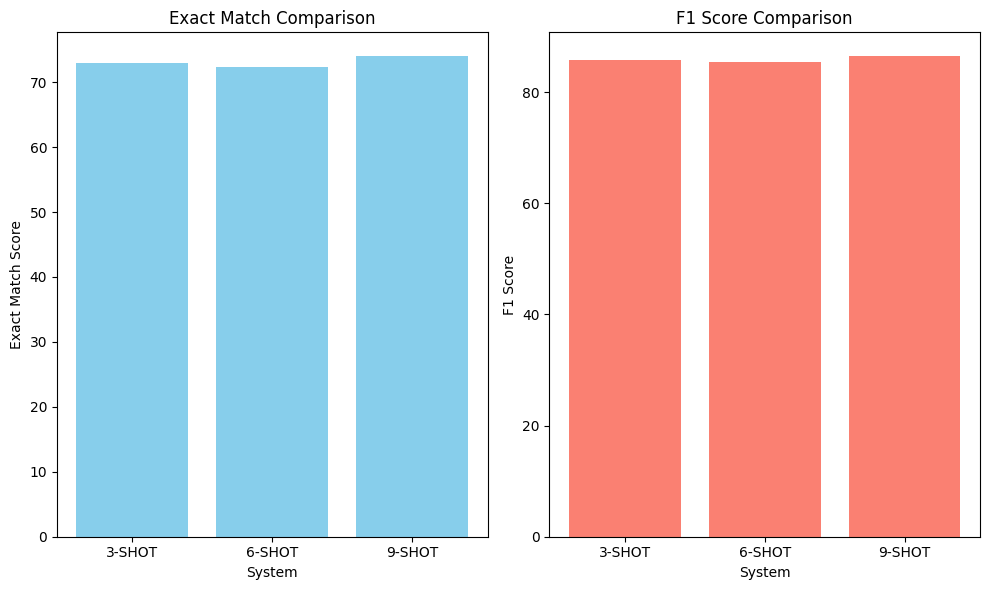

In [ ]:
# Data
systems = ['3-SHOT', '6-SHOT', '9-SHOT']
exact_match_scores = [average_exact_match_3_shot, average_exact_match_6_shot, average_exact_match_9_shot]
f1_scores = [average_f1_3_shot, average_f1_6_shot, average_f1_9_shot]

# Plot
plt.figure(figsize=(10, 6))

# Plot Exact Match
plt.subplot(1, 2, 1)
plt.bar(systems, exact_match_scores, color='skyblue')
plt.title('Exact Match Comparison')
plt.xlabel('System')
plt.ylabel('Exact Match Score')

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.bar(systems, f1_scores, color='salmon')
plt.title('F1 Score Comparison')
plt.xlabel('System')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Few-shot with best k-value(number of demonstrations)

In [ ]:
few_best_shot_results = []

for index, example in enumerate(test_dataset):
    # Example index to answer is the current index in the validation dataset
    example_index_to_answer = index

    # Generate one-shot learning prompt
    few_best_shot_prompt = make_prompt([40, 80, 120, 130, 140, 150, 160, 170, 180], example)
    # Encode input for one-shot learning
    inputs_encoded = tokenizer(few_best_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    few_best_output = tokenizer.decode(model_output, skip_special_tokens=True)
    true_answer = example['answers']['text']
    evaluation_results = evaluate([true_answer], [few_best_output])

    few_best_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'few_best_output': few_best_output,
        'evaluation_results': evaluation_results
    })

few_best_shot_results_df = pd.DataFrame(few_best_shot_results)
few_best_shot_results_df.to_csv('best_shot_results_with_answers_exact_match_and_f1.csv', index=False)

In [ ]:
few_best_shot_results_df = pd.read_csv('best_shot_results_with_answers_exact_match_and_f1.csv')
few_best_shot_results_df

,context,question,true_answer,few_best_output,evaluation_results
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"['Carolina Panthers', 'Carolina Panthers', 'Ca...",Carolina Panthers,"{'exact_match': 100.0, 'f1': 100.0}"
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"['Santa Clara, California', ""Levi's Stadium"", ...",Levi's Stadium,"{'exact_match': 100.0, 'f1': 100.0}"
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"['gold', 'gold', 'gold']",gold,"{'exact_match': 100.0, 'f1': 100.0}"
...,...,...,...,...,...
10565,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"['kilogram-force', 'pound-force', 'kilogram-fo...",pound-force,"{'exact_match': 100.0, 'f1': 100.0}"
10566,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"['kilopond', 'kilopond', 'kilopond', 'kilopond...",kilopond,"{'exact_match': 100.0, 'f1': 100.0}"
10567,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"['slug', 'metric slug', 'metric slug', 'metric...",slug,"{'exact_match': 100.0, 'f1': 100.0}"
10568,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"['kip', 'kip', 'kip', 'kip', 'kip']",kip,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
# Compute the average exact match and F1 scores
average_exact_match_best_few_shot = few_best_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_best_few_shot = few_best_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_best_few_shot)
print("Average F1 Score:", average_f1_best_few_shot)

Average Exact Match: 80.93661305581836
Average F1 Score: 88.87882206232676


#Plot system comparison for 0-,1-,9-shot systems in both metrics (EM) (F1)

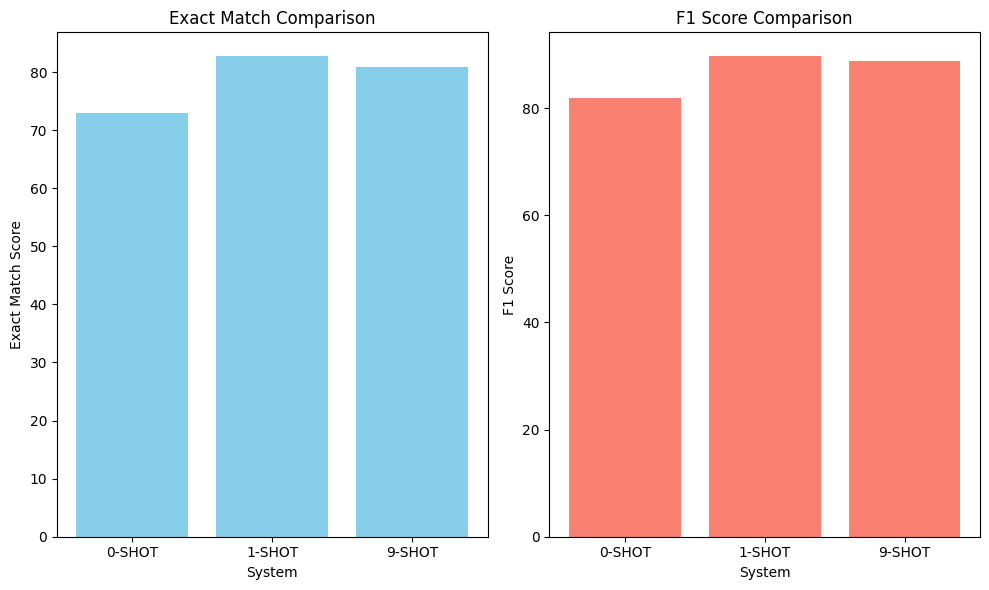

In [ ]:
# Data
systems = ['0-SHOT', '1-SHOT', '9-SHOT']
exact_match_scores = [average_exact_match_0_shot, average_exact_match_1_shot, average_exact_match_best_few_shot]
f1_scores = [average_f1_0_shot, average_f1_1_shot, average_f1_best_few_shot]

# Plot
plt.figure(figsize=(10, 6))

# Plot Exact Match
plt.subplot(1, 2, 1)
plt.bar(systems, exact_match_scores, color='skyblue')
plt.title('Exact Match Comparison')
plt.xlabel('System')
plt.ylabel('Exact Match Score')

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.bar(systems, f1_scores, color='salmon')
plt.title('F1 Score Comparison')
plt.xlabel('System')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

#Extra Experiment: Few shot with classified questions
In this experiment we use 11 shots, one for each of the following question types, to make sure that the shots cover a wider range of possible questions during inference.

An initial, superficial classification was conducted based on the pronoun the question starts with, and can be extended with a more sophisticated classification methodology.

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
# Define the question types
questionTypes = {"What", "How many", "How", "Whom", "Whose", "Who", "When", "Which", "Where", "Why", "Be/Do/etc."}

def classify_question_type(question):
    tokens = word_tokenize(question)
    tagged_tokens = pos_tag(tokens)
    first_word = tagged_tokens[0][0]
    if first_word in questionTypes:
        return first_word
    elif first_word.lower() in ["is", "are", "do", "does"]:
        return "Be/Do/etc."
    else:
        return "Other"

from collections import defaultdict

# Function to classify questions in the dataset and select one example from each question type
def create_dataset_with_one_example_per_type(dataset):
    classified_questions = defaultdict(list)

    for example in dataset:
        question = example["question"]
        context = example['context']
        answer = example['answers']
        question_type = classify_question_type(question)

        # Add the example to the list of examples for this question type
        classified_questions[question_type].append(example)
    for question_type, examples in classified_questions.items():
      print(question_type, len(examples))

# Print out the expected question types
    print(questionTypes)
    # Select one example from each question type
    dataset_with_one_example_per_type = []
    for question_type, examples in classified_questions.items():
        dataset_with_one_example_per_type.append(examples[0])  # Select the first example

    return dataset_with_one_example_per_type

# Create a new dataset with one example from each question type
new_dataset = create_dataset_with_one_example_per_type(train_dataset)
print(len(new_dataset))  # Print the number of examples in the new dataset

Other 18234
What 35475
When 5056
How 7689
Where 3083
Which 4052
Who 7714
Why 1109
Be/Do/etc. 601
Whose 184
Whom 22
{'Who', 'Why', 'What', 'Whom', 'Be/Do/etc.', 'How', 'Whose', 'When', 'Where', 'How many', 'Which'}
11


In [ ]:
# Print the first 5 examples
for example in new_dataset:
    print("Context:", example['context'])
    print("Question:", example['question'])
    print("Answers:", example['answers'])
    print("-" * 50)

Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answers: {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}
--------------------------------------------------
Context: Architecturally, the school has a Catholic character. Atop the Main Building's g

In [ ]:
def make_exp_prompt(example_indices, dataset):
    prompt = ""
    for index in example_indices:
        context = new_dataset[index]['context']
        question = new_dataset[index]['question']
        answer = new_dataset[index]['answers']

        prompt += f"""
        Passage:
        {context}

        Read the passage above and answer the following question:
        {question}

        The answer is:
        {answer}
        """

    context_to_answer = dataset['context']
    question_to_answer = dataset['question']
    prompt += f"""
        Passage:
        {context_to_answer}

        Read the passage above and answer the following question:
        {question_to_answer}

        The answer is:
        """

    return prompt

In [ ]:
exp_few_shot_results = []

for index, example in enumerate(test_dataset):
    # Example index to answer is the current index in the validation dataset
    example_index_to_answer = index

    # Generate one-shot learning prompt
    exp_few_shot_prompt = make_exp_prompt([0,1,2,3,4,5,6,7,8,9,10], example)

    # Encode input for one-shot learning
    inputs_encoded = tokenizer(exp_few_shot_prompt, return_tensors='pt')

    # Generate model output using one-shot learning
    model_output = model.generate(inputs_encoded["input_ids"].to(device), generation_config=generation_config)[0]

    # Decode the output
    exp_few_output = tokenizer.decode(model_output, skip_special_tokens=True)

    true_answer = example['answers']['text']
    evaluation_results = evaluate([true_answer], [exp_few_output])  # Wrap true_answer in a list


    exp_few_shot_results.append({
        'context': example['context'],
        'question': example['question'],
        'true_answer': true_answer,
        'exp_few_output': exp_few_output,
        'evaluation_results': evaluation_results
    })

exp_few_shot_results_df = pd.DataFrame(exp_few_shot_results)
exp_few_shot_results_df.to_csv('exp_few_shot_results_with_answers_exact_match_and_f1.csv', index=False)

In [ ]:
exp_few_shot_results_df = pd.read_csv('exp_few_shot_results_with_answers_exact_match_and_f1.csv')
exp_few_shot_results_df

,context,question,true_answer,exp_few_output,evaluation_results
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"['Carolina Panthers', 'Carolina Panthers', 'Ca...",Carolina Panthers,"{'exact_match': 100.0, 'f1': 100.0}"
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"['Santa Clara, California', ""Levi's Stadium"", ...",Levi's Stadium,"{'exact_match': 100.0, 'f1': 100.0}"
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"['Denver Broncos', 'Denver Broncos', 'Denver B...",Denver Broncos,"{'exact_match': 100.0, 'f1': 100.0}"
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"['gold', 'gold', 'gold']",gold,"{'exact_match': 100.0, 'f1': 100.0}"
...,...,...,...,...,...
10565,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"['kilogram-force', 'pound-force', 'kilogram-fo...",pound-force,"{'exact_match': 100.0, 'f1': 100.0}"
10566,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"['kilopond', 'kilopond', 'kilopond', 'kilopond...",kilopond,"{'exact_match': 100.0, 'f1': 100.0}"
10567,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"['slug', 'metric slug', 'metric slug', 'metric...",slug,"{'exact_match': 100.0, 'f1': 100.0}"
10568,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"['kip', 'kip', 'kip', 'kip', 'kip']",kip,"{'exact_match': 100.0, 'f1': 100.0}"


In [ ]:
# Compute the average exact match and F1 scores
average_exact_match_exp_few_shot = exp_few_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['exact_match']).mean()
average_f1_exp_few_shot = exp_few_shot_results_df['evaluation_results'].apply(lambda x: eval(x)['f1']).mean()

print("Average Exact Match:", average_exact_match_exp_few_shot)
print("Average F1 Score:", average_f1_exp_few_shot)

Average Exact Match: 82.34626300851467
Average F1 Score: 89.83955263087766


#Final plots for comparison

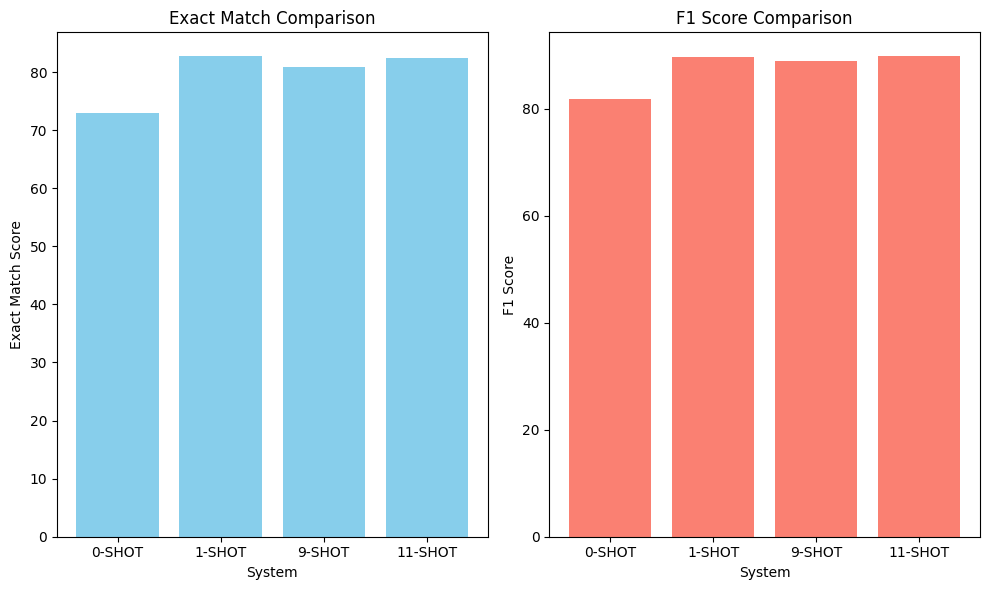

In [ ]:
# Data
systems = ['0-SHOT', '1-SHOT', '9-SHOT', '11-SHOT']
exact_match_scores = [average_exact_match_0_shot, average_exact_match_1_shot, average_exact_match_best_few_shot, average_exact_match_exp_few_shot]
f1_scores = [average_f1_0_shot, average_f1_1_shot, average_f1_best_few_shot,average_f1_exp_few_shot ]

# Plot
plt.figure(figsize=(10, 6))

# Plot Exact Match
plt.subplot(1, 2, 1)
plt.bar(systems, exact_match_scores, color='skyblue')
plt.title('Exact Match Comparison')
plt.xlabel('System')
plt.ylabel('Exact Match Score')

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.bar(systems, f1_scores, color='salmon')
plt.title('F1 Score Comparison')
plt.xlabel('System')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()